# Importing Libraries

In [ ]:
# นำเข้าไลบรารี PyTorch และโมดูลที่เกี่ยวข้อง
import torch
import torch.nn as nn
import torch.optim as optim

# นำเข้าไลบรารี torchvision สำหรับการทำงานกับชุดข้อมูลทางวิทยาศาสตร์คอมพิวเตอร์
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# นำเข้าไลบรารีเสริมสำหรับการทำ visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# preparing Dataset

In [ ]:
# นำเข้าไลบรารี drive จาก google.colab
from google.colab import drive

# Mount (เชื่อมต่อ) Google Drive ที่เก็บข้อมูลไว้
# '/content/drive' เป็นตำแหน่งที่จะทำการเชื่อมต่อ Google Drive ใน Colab
# force_remount=True เป็นการบังคับให้ทำการเชื่อมต่อใหม่ทุกครั้งเมื่อเรียกใช้
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


เชื่อมกับ Google Drive เพื่อเข้าถึงข้อมูลของเรา

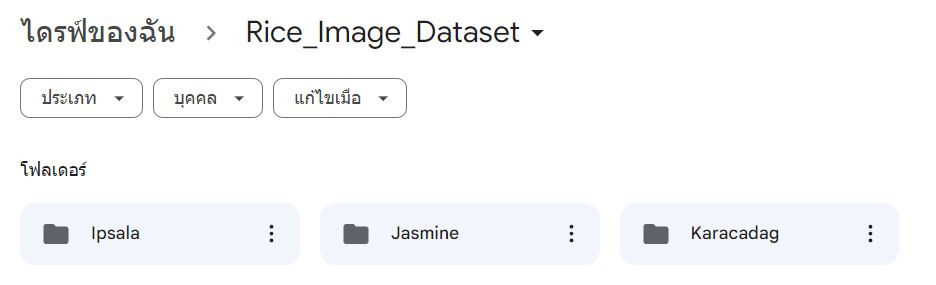

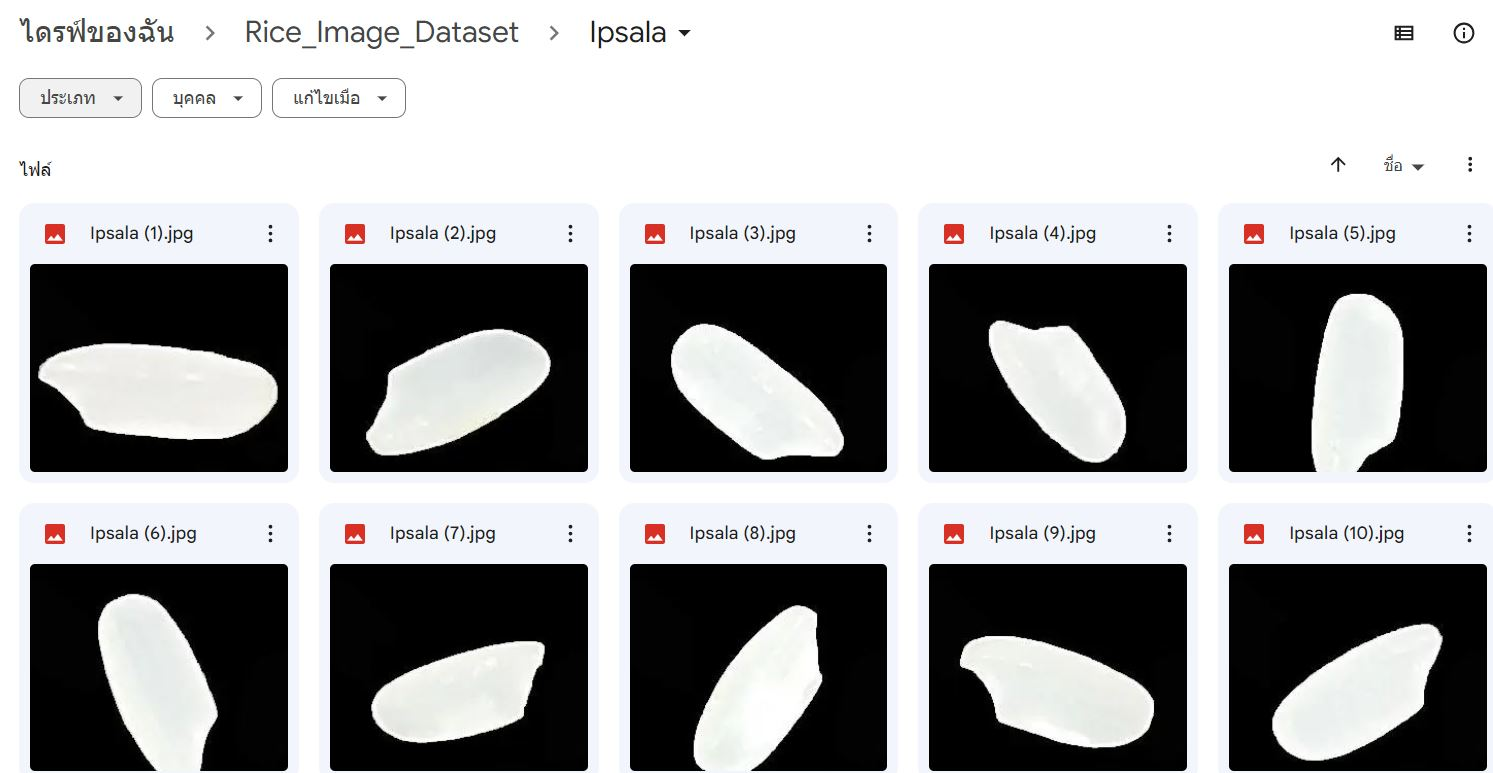

In [ ]:
# กำหนดที่อยู่ของ dataset ที่เก็บไว้ใน Google Drive
data_dir = '/content/drive/MyDrive/Rice_Image_Dataset'

# กำหนดการทำ transform บน dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # ปรับขนาดรูปภาพเป็น 128x128 pixels
    transforms.ToTensor(),  # แปลงรูปภาพเป็น tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ทำ normalization ของ tensor
])

# โหลด dataset โดยใช้ ImageFolder และกำหนด transform
dataset = ImageFolder(root=data_dir, transform=transform)

# สุ่มตัวอย่างแบบ random sampling

In [ ]:
# กำหนดขนาดของชุดฝึก (70%), ชุดทดสอบ (15%), และชุดทดสอบ (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# ใช้ random_split เพื่อแบ่ง dataset เป็นชุดฝึก (train), ชุดทดสอบ (validation), และชุดทดสอบ (test)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


Train 70% |  Test 15% | Validation 15%

# แสดงรูปแต่ละสายพันธ์ของข้าวโดยรวม

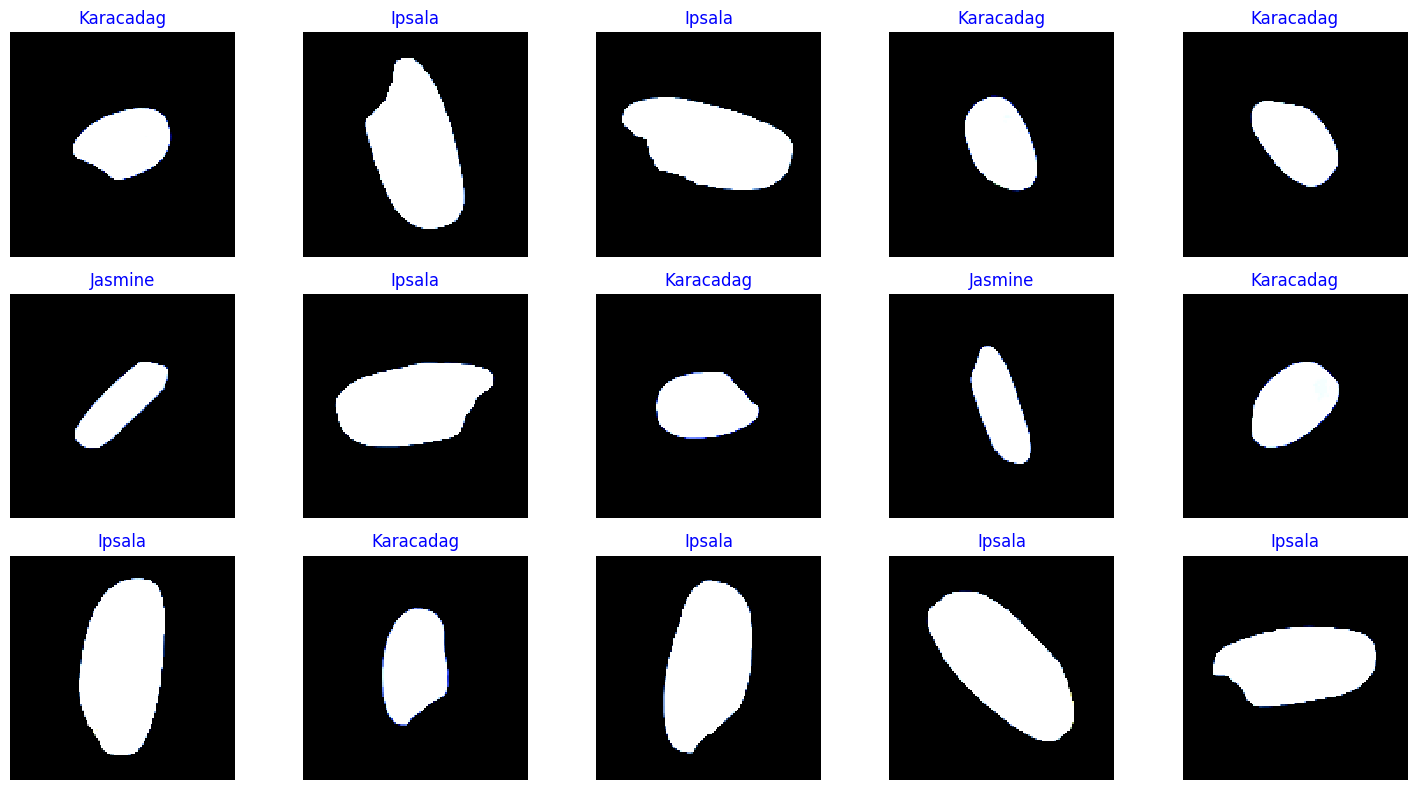

In [ ]:
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# สร้าง DataLoader
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)

# แสดงรูปภาพ
for images, labels in train_loader:
    plt.figure(figsize=(15, 8))

    # แสดงรูปแต่ละรูปของ batch
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(image.numpy().transpose((1, 2, 0)), interpolation='nearest')
        plt.title(dataset.classes[label], color='blue', fontsize=12)
        plt.axis(False)

    plt.tight_layout()
    plt.show()
    break  # แสดงเพียง batch เดียว


ในที่นี้มีอยู่ 3 สายพันธ์

# สร้าง DataLoader

In [ ]:
# กำหนดขนาดของ batch
batch_size = 32

# สร้าง DataLoader สำหรับชุดฝึก (training set)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# สร้าง DataLoader สำหรับชุดทดสอบ (validation set)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# สร้าง DataLoader สำหรับชุดทดสอบ (test set)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Create Model CNN (Convolutional Neural Network)

In [ ]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # ระบุชั้น Convolutional และ Fully Connected
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # การทำ forward pass ของโมเดล
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ปรับจำนวนคลาสใน dataset.classes
num_classes = len(dataset.classes)

# สร้างโมเดล CNN ด้วยจำนวนคลาสที่ถูกปรับ
model = CNNModel(num_classes)


การกำหนดโมเดล (Model Definition):

CNNModel เป็นคลาสที่สืบทอดมาจาก nn.Module ซึ่งเป็นฐานของ PyTorch สำหรับการสร้างโมเดล.

__init__ เป็นเมธอดที่ถูกเรียกในขั้นตอนการสร้างอ็อบเจ็กต์ของคลาส และใช้ในการกำหนดและสร้างชั้น (layers) ของโมเดล.

ชั้นที่ใช้ประกอบด้วย:

nn.Conv2d(3, 16, kernel_size=3, padding=1): ชั้น Convolutional ที่ใช้ 3 ช่องสี (RGB) ในข้อมูลนำเข้า, 16 แชนแนล, และใช้ kernel ขนาด 3x3 พร้อม padding 1.
nn.Conv2d(16, 32, kernel_size=3, padding=1): ชั้น Convolutional ที่ใช้ 16 แชนแนลจากชั้นก่อนหน้า, 32 แชนแนล, และใช้ kernel ขนาด 3x3 พร้อม padding 1.
nn.MaxPool2d(kernel_size=2, stride=2): ชั้น MaxPooling ขนาด 2x2 ที่ใช้ในการลดขนาดของภาพ.
nn.Linear(32 * 32 * 32, 128): ชั้น Fully Connected ที่รับข้อมูลขนาด 32x32x32 (จากการใช้ view ในการปรับรูปร่าง) และส่งออกข้อมูลขนาด 128.
nn.Linear(128, num_classes): ชั้น Fully Connected สุดท้ายที่รับข้อมูลขนาด 128 และส่งออกจำนวนคลาสเท่ากับ num_classes.
forward เป็นเมธอดที่นิยมใช้ในการกำหนดขั้นตอนในการทำ Forward Pass ของโมเดล. ในที่นี้, มีขั้นตอนการทำ Convolution, ReLU Activation, MaxPooling, และ Fully Connected.

การสร้างโมเดล:

num_classes ถูกกำหนดโดยใช้จำนวนคลาสจาก dataset.classes ซึ่งเป็นส่วนหนึ่งของ dataset ที่ใช้ในโปรแกรม.
จากนั้น, โมเดลถูกสร้างขึ้นโดยให้ num_classes มีค่าเป็นจำนวนคลาสที่ได้จาก dataset.
การสร้างโมเดลด้วย CNN:

โมเดลถูกสร้างด้วยการสร้างอ็อบเจ็กต์ของ CNNModel โดยใช้ num_classes ที่ถูกปรับเป็นจำนวนคลาสใน dataset.
สรุป, โมเดล CNN นี้ถูกออกแบบขึ้นเพื่อทำนายหรือจำแนกประเภทของข้อมูลภาพ, โดยมีชั้น Convolutional, MaxPooling, และ Fully Connected ที่ถูกกำหนดไว้ในคลาส CNNModel นี้.

# Count of classes present in the dataset.

In [ ]:
num_classes # นับจำนวนคลาสที่มีใน dataset
print(f'num_classes : ', num_classes)
class_names = dataset.classes
class_names

num_classes :  3


['Ipsala', 'Jasmine', 'Karacadag']

In [ ]:
model # โมเดล CNN ที่ถูกสร้าง

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # ตัวคำนวณ loss ด้วย CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer Adam ที่ใช้ในการอัพเดตพารามิเตอร์ของโมเดล

# training and testing the CNN model

In [ ]:
num_epochs = 5

train_losses = []        # รายการเก็บค่า loss ในแต่ละ epoch ของชุดฝึก
val_losses = []          # รายการเก็บค่า loss ในแต่ละ epoch ของชุดทดสอบ
val_accuracies = []      # รายการเก็บค่าความแม่นยำในแต่ละ epoch ของชุดทดสอบ

for epoch in range(num_epochs):
    model.train()         # สลับโหมดเป็นโหมดฝึก
    running_loss = 0.0

    # วนลูปผ่าน mini-batches ในชุดฝึก
    for inputs, labels in train_loader:
        optimizer.zero_grad()    # เซ็ต gradient เป็นศูนย์
        outputs = model(inputs)   # forward pass
        loss = criterion(outputs, labels)  # คำนวณค่า loss
        loss.backward()          # backward pass
        optimizer.step()         # อัพเดตพารามิเตอร์

        running_loss += loss.item()  # เพิ่มค่า loss ใน mini-batch ปัจจุบัน

    train_loss = running_loss / len(train_loader)  # คำนวณค่า loss ของชุดฝึกในแต่ละ epoch
    train_losses.append(train_loss)  # เก็บค่า loss ในรายการ

    model.eval()  # สลับโหมดเป็นโหมด evaluate สำหรับทดสอบ
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        # วนลูปผ่าน mini-batches ในชุดทดสอบ
        for inputs, labels in val_loader:
            outputs = model(inputs)   # forward pass
            loss = criterion(outputs, labels)  # คำนวณค่า loss
            val_loss += loss.item()   # เพิ่มค่า loss ใน mini-batch ปัจจุบัน

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / len(val_dataset)  # คำนวณความแม่นยำของชุดทดสอบในแต่ละ epoch
    val_losses.append(val_loss / len(val_loader))  # เก็บค่า loss ในรายการ
    val_accuracies.append(val_accuracy)  # เก็บค่าความแม่นยำในรายการ

    # แสดงผลลัพธ์ที่ได้ในแต่ละ epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/5] - Train Loss: 0.0522, Validation Loss: 0.0008, Validation Accuracy: 1.0000
Epoch [2/5] - Train Loss: 0.0023, Validation Loss: 0.0008, Validation Accuracy: 1.0000
Epoch [3/5] - Train Loss: 0.0010, Validation Loss: 0.0002, Validation Accuracy: 1.0000
Epoch [4/5] - Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch [5/5] - Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 1.0000


สรุป, โค้ดที่ให้มีไว้สำหรับการฝึกและทดสอบโมเดล CNN ในแต่ละ epoch และบันทึกค่า loss และความแม่นยำเพื่อการวิเคราะห์และปรับปรุงโมเดล.

# Show Test Accuracy:

In [ ]:
correct = 0  # จำนวนที่ทำนายถูก
total = 0  # จำนวนทั้งหมด

# ไม่คำนึงถึง gradient ในการทดสอบ
with torch.no_grad():
    model.eval()  # สลับโหมดเป็นโหมด evaluate
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# คำนวณความแม่นยำ
accuracy = correct / total

# แสดงผลลัพธ์
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 1.00


# บันทึกโมเดลลงในไฟล์เพื่อให้สามารถนำไปใช้งานหรือฝึกต่อในภายหลังได้

In [ ]:
# save model เพื่อไปปใช้งานในภายหลังได้

torch.save(model.state_dict(), 'rice_model.pth')

# กราฟแสดงค่า loss ของชุดฝึกและชุดทดสอบ

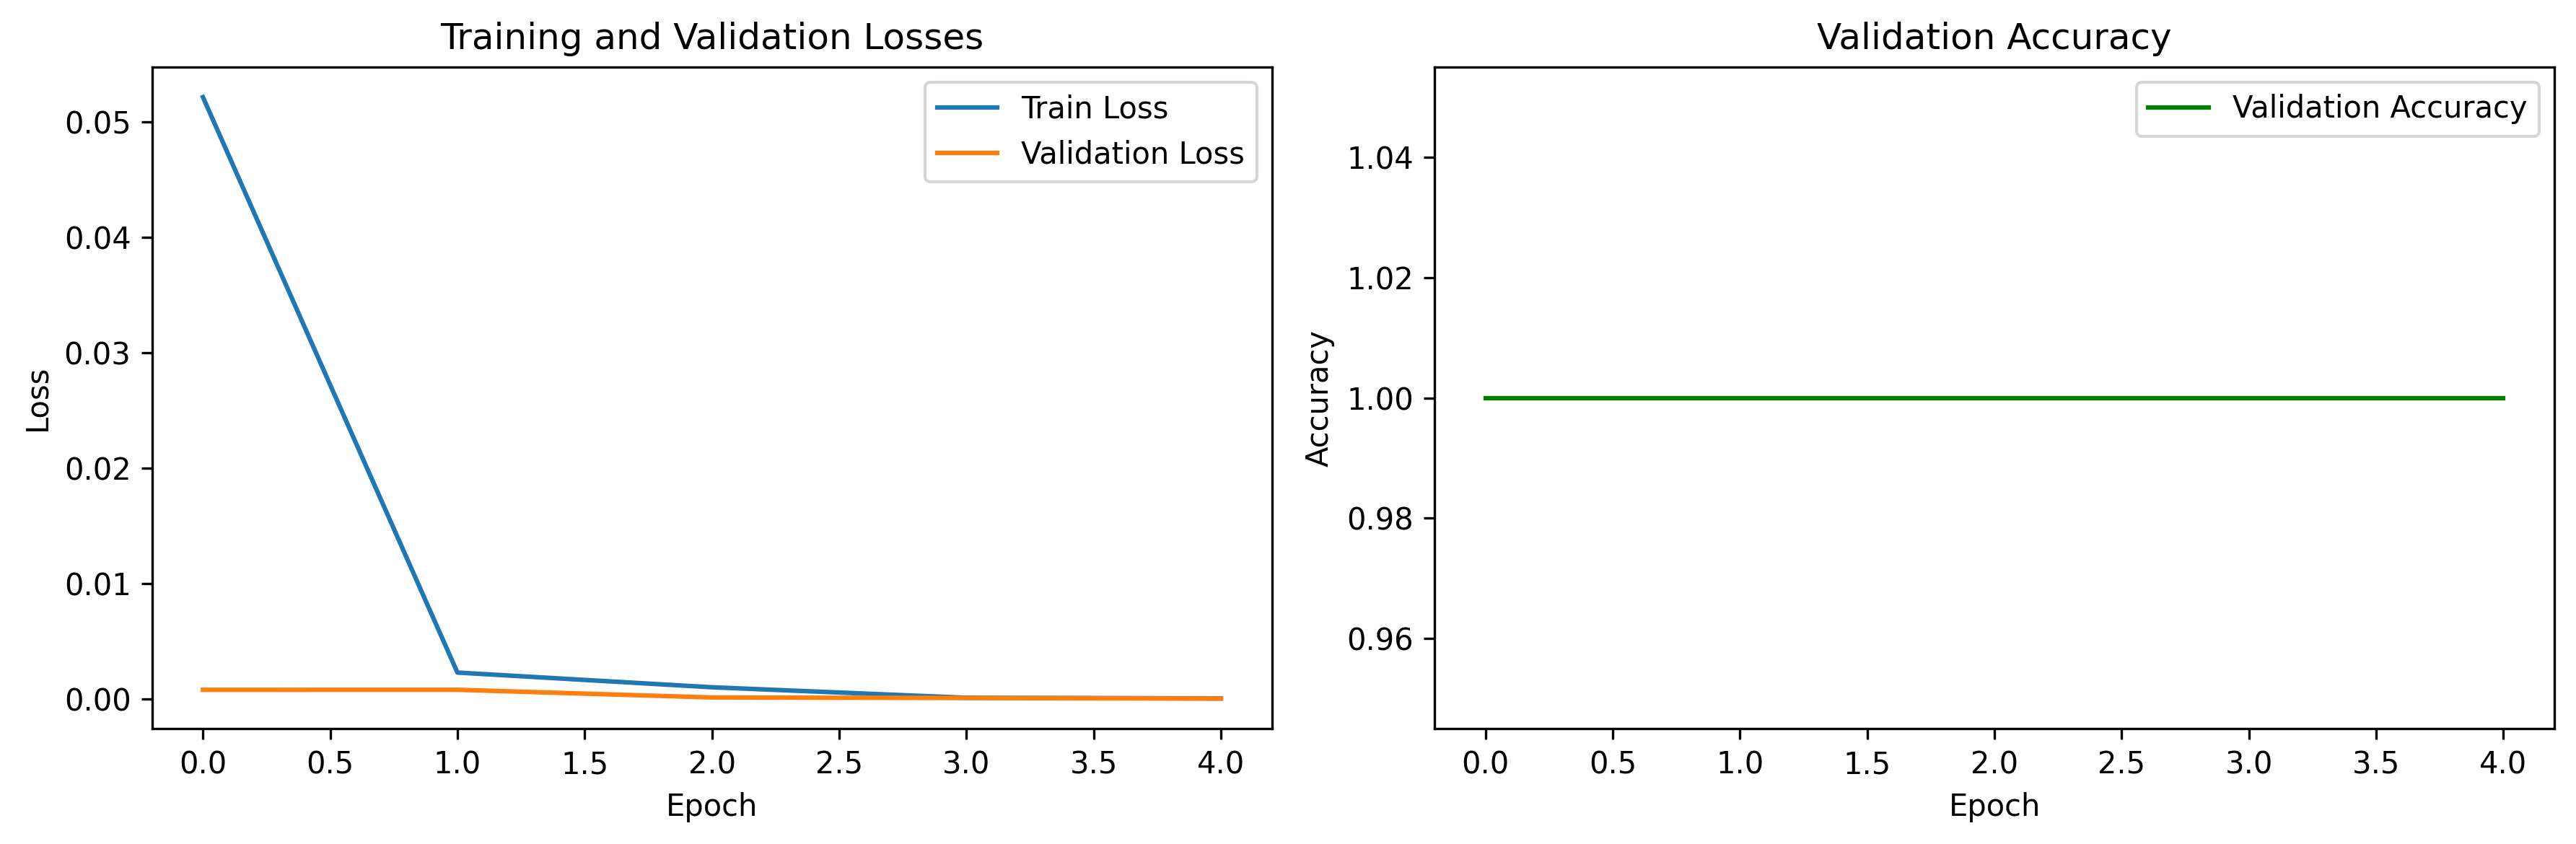

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4), dpi=300)

# กราฟแสดงค่า loss ของชุดฝึกและชุดทดสอบ (validation)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# กราฟแสดงความแม่นยำของชุดทดสอบ
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# ปรับแต่งรูปแบบและแสดงกราฟ
plt.tight_layout()
plt.show()


# Evaluate Model

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

# สมมติว่า test_loader ของคุณให้ข้อมูลเป็น batch ที่สามารถเข้าถึง inputs และ labels ได้
all_predicted = []  # เก็บผลลัพธ์การทำนายทั้งหมด
all_labels = []  # เก็บ label ทั้งหมด

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())  # เก็บผลลัพธ์การทำนาย
        all_labels.extend(labels.cpu().numpy())  # เก็บ label จริง

# แปลง list เป็น PyTorch tensors
all_labels_tensor = torch.tensor(all_labels)
all_predicted_tensor = torch.tensor(all_predicted)

# คำนวณค่า precision, recall, F1 score, และ accuracy
precision = precision_score(all_labels_tensor, all_predicted_tensor, average='weighted')
recall = recall_score(all_labels_tensor, all_predicted_tensor, average='weighted')
f1 = f1_score(all_labels_tensor, all_predicted_tensor, average='weighted')
accuracy = accuracy_score(all_labels_tensor, all_predicted_tensor)

# แสดงค่า precision, recall, F1 score, และ accuracy
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# แสดง classification report และ confusion matrix
print("Classification Report:")
print(classification_report(all_labels_tensor, all_predicted_tensor))

print("Confusion Matrix:")
print(confusion_matrix(all_labels_tensor, all_predicted_tensor))

Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       234
           2       1.00      1.00      1.00       225

    accuracy                           1.00       675
   macro avg       1.00      1.00      1.00       675
weighted avg       1.00      1.00      1.00       675

Confusion Matrix:
[[216   0   0]
 [  0 234   0]
 [  0   0 225]]


# Confusion Matrix

Confusion Matrix ถือเป็นเครื่องมือสำคัญในการประเมินผลลัพธ์ของการทำนาย หรือ Prediction ที่ทำนายจากModelที่เราสร้างขึ้น ในMachine learning โดยมีไอเดียจากการวัดว่า สิ่งที่เราคิด (Model ทำนาย) กับ สิ่งที่เกิดขึ้นจริง มีสัดส่วนเป็นอย่างไร

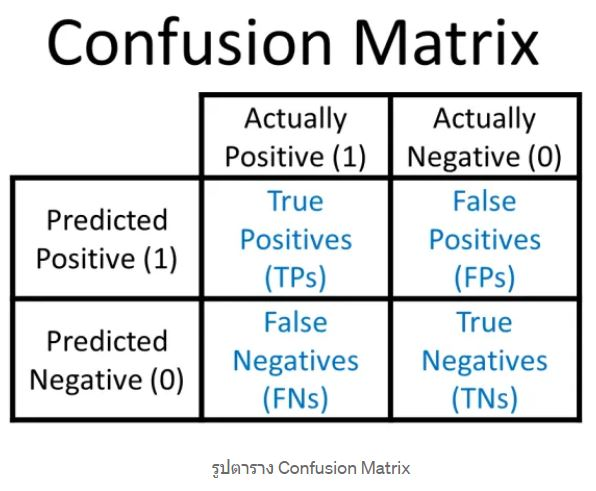

True Positive (TP)= สิ่งที่ทำนาย ตรงกับสิ่งที่เกิดขึ้นจริง ในกรณี ทำนายว่าจริง และสิ่งที่เกิดขึ้น ก็คือ จริง

True Negative (TN)= สิ่งที่ทำนายตรงกับสิ่งที่เกิดขึ้น ในกรณี ทำนายว่า ไม่จริง และสิ่งที่เกิดขึ้น ก็คือ ไม่จริง

False Positive (FP)= สิ่งที่ทำนายไม่ตรงกับสิ่งที่เกิดขึ้น คือทำนายว่า จริง แต่สิ่งที่เกิดขึ้น คือ ไม่จริง

False Negative (FN)= สิ่งที่ทำนายไม่ตรงกับที่เกิดขึ้นจริง คือทำนายว่าไม่จริง แต่สิ่งที่เกิดขึ้น คือ จริง

โดย TP,TN,FP,FN ในตารางจะแทนด้วยค่าความถี่

เราสามารถใช้ Confusion Matrix มาคำนวน การประเมินประสิทธิภาพของการทำนายด้วยModel ของเรา ในรูปแบบค่าต่างๆได้หลายค่า

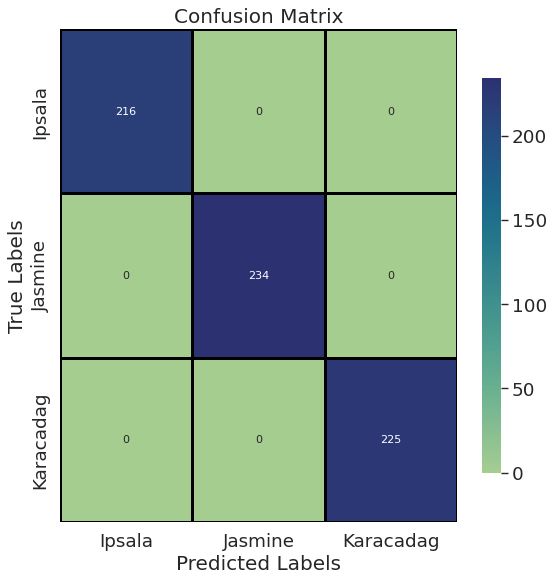

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# คำนวณ Confusion Matrix
cm = confusion_matrix(all_labels, all_predicted)

# ตั้งค่าขนาดและรูปแบบของกราฟ
sns.set(font_scale=1.5)  # ปรับขนาดตัวหนังสือให้ใหญ่ขึ้น
plt.figure(figsize=(8, 8), dpi=80)  # ปรับขนาดของกราฟเล็กลง

# สร้าง Heatmap แสดง Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidths=1,
            linecolor="black", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 10}, cbar_kws={"shrink": 0.8})  # ปรับขนาดตัวหนังสือและแถบสี

# กำหนดป้ายชื่อแกน x, y และชื่อกราฟ
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# แสดงกราฟ
plt.show()


จากกรณีของเราจะเห็นได้ว่า โมเดลมีประสิทธิภาพสูงมากในการจำแนกสายพันธ์ของข้าวทั้งสามสายพันธ์

# ลองใช้ข้อมูล test_loader ในการทำนายสายพันธ์ของข้าว เพื่อดูว่าโมเดลมีความแม่นยำหรือไม่

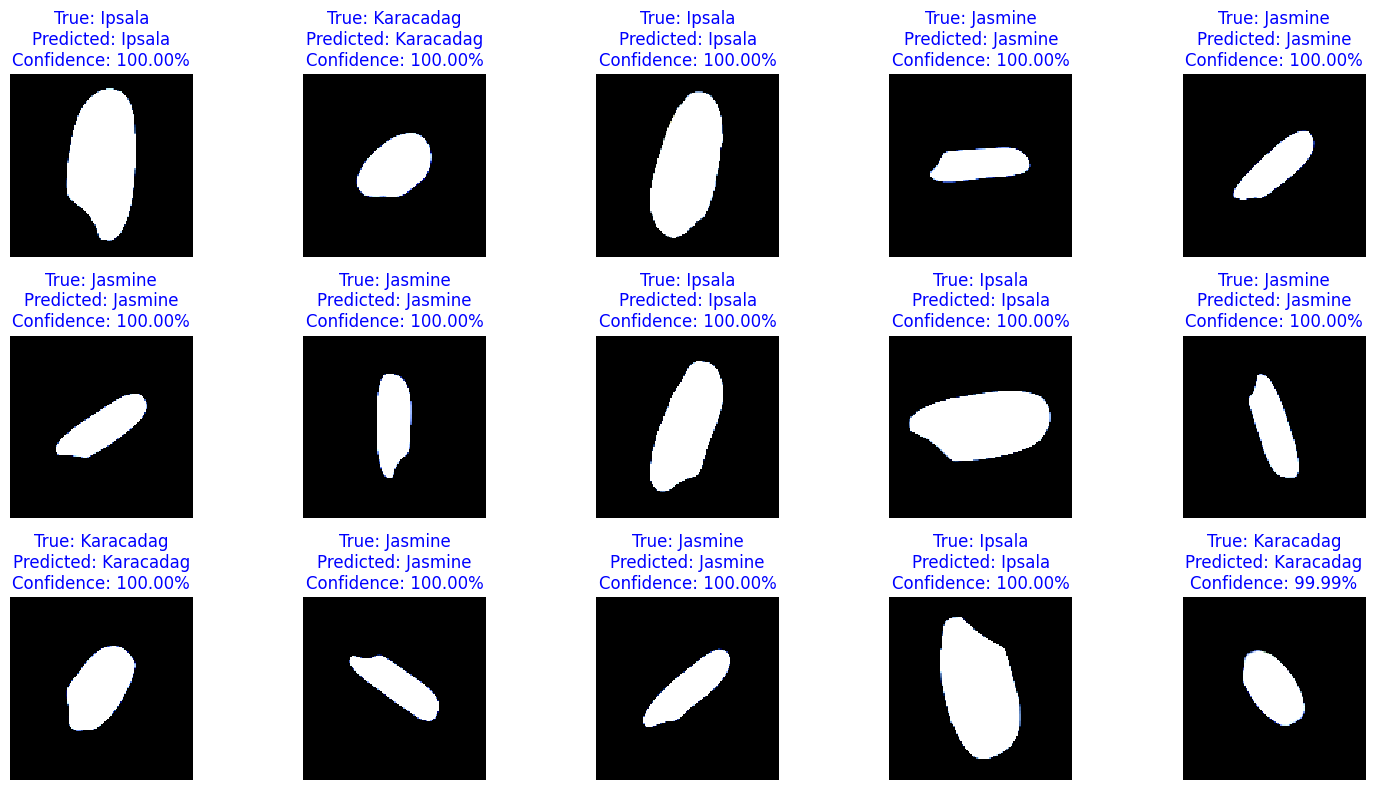

In [ ]:
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F

# สร้าง DataLoader
test_loader = DataLoader(dataset, batch_size=15, shuffle=True)

# ให้โมเดลทำนาย
def predict(model, images):
    outputs = model(images)
    probabilities = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)
    return predicted, probabilities

# แสดงรูปภาพและ label
for images, labels in test_loader:
    plt.figure(figsize=(15, 8))

    # แสดงรูปแต่ละรูปของ batch
    for i, (image, label) in enumerate(zip(images, labels)):
        predicted, probabilities = predict(model, image.unsqueeze(0))
        predicted_label = dataset.classes[predicted.item()]
        confidence = torch.max(probabilities).item() * 100
        plt.subplot(3, 5, i + 1)
        plt.imshow(image.numpy().transpose((1, 2, 0)), interpolation='nearest')
        plt.title(f"True: {dataset.classes[label]}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%", color='blue', fontsize=12)
        plt.axis(False)

    plt.tight_layout()
    plt.show()
    break  # แสดงเพียง batch เดียว


# ทำนายสายพันธ์ข้าวที่เราต้องการ

ในที่นี้ลองใส่ สายพันธ์ Ipsala ซึ่งโมเดลก็ทำนายได้ถูกต้องและแม่นยำ

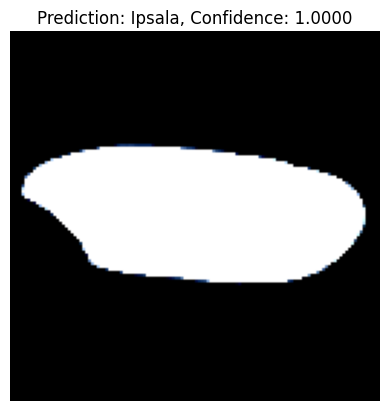

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# โหลดโมเดล ที่เราพัฒนาเสร็จแล้วมาใช้งาน
model_path = "/content/rice_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

# เลือกรูปภาพที่ต้องการทดสอบ
test_image_path = "/content/Ipsala (1).jpg"

# อ่านรูปภาพและทำการปรับปรุงตามการแปลงที่ใช้ในการเทรน
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_image = Image.open(test_image_path)
test_image_tensor = transform(test_image)

# เพิ่ม batch dimension ด้วย unsqueeze
test_image_tensor = test_image_tensor.unsqueeze(0)

# ทำการทำนาย
with torch.no_grad():
    predictions = model(test_image_tensor)

# แปลงผลลัพธ์เป็นคลาสที่สูงที่สุด
predicted_class = torch.argmax(predictions).item()

# แปลงเลขคลาสเป็นชื่อสายพันธ์
class_names = ['Ipsala', 'Jasmine', 'Karacadag']
predicted_class_name = class_names[predicted_class]

# คำนวณค่า confidence
confidence = torch.nn.functional.softmax(predictions, dim=1)[0][predicted_class].item()

# แสดงรูปภาพพร้อม Label และ Confidence
plt.imshow(test_image_tensor.squeeze().permute(1, 2, 0))
plt.title(f"Prediction: {predicted_class_name}, Confidence: {confidence:.4f}")
plt.axis('off')
plt.show()